In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import norm

import sys
sys.path.append('../utils')
from utils import *

In [2]:
data = retrieve_data()
data = data.dropna()
data

,Date,ROG_Last_Price,ROG_IVOL,CFR_Last_Price,CFR_IVOL,ZURN_Last_Price,ZURN_IVOL,Risk_Free_Rate
0,2023-10-25,237.55,17.6858,107.00,33.0793,426.4,15.7900,1.4594
1,2023-10-26,237.25,17.9504,104.45,33.5406,426.8,15.9736,1.4508
2,2023-10-27,237.75,19.6028,104.40,33.4355,424.4,16.3945,1.4478
3,2023-10-30,241.30,19.3503,104.75,33.1531,428.2,15.9477,1.4623
4,2023-10-31,233.85,19.2518,106.90,32.7788,430.6,15.7948,1.4489
...,...,...,...,...,...,...,...,...
247,2024-10-18,273.30,18.5418,127.45,28.9419,527.4,14.1825,0.6383
248,2024-10-21,272.90,17.7575,126.65,31.1486,526.2,14.1699,0.6532
249,2024-10-22,272.20,18.2963,126.95,30.9890,520.4,14.7228,0.6544
250,2024-10-23,277.20,17.6974,126.05,31.3139,519.6,14.0134,0.6448


In [3]:
data[data['Date'] == '2024-07-25']

,Date,ROG_Last_Price,ROG_IVOL,CFR_Last_Price,CFR_IVOL,ZURN_Last_Price,ZURN_IVOL,Risk_Free_Rate
187,2024-07-25,277.5,18.2666,131.2,23.415,474.6,14.5858,0.8649


In [4]:
product_price_df = pd.read_csv(f'../data/product_price.csv')
print(product_price_df.head())

       Date Product 
0  25/10/24   98.55%
1  24/10/24   98.61%
2  23/10/24   98.55%
3  22/10/24   98.64%
4  21/10/24   98.79%


# Heston Stochastic Volatility Model 

hinh nhu phai dung option price to calibrate :(

# 1. Heston Calibrate

![Math](heston1.png)

In [5]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Load your data
dates = pd.to_datetime(data['Date'])
ROG_IVOL = data['ROG_IVOL'].values / 100
CFR_IVOL = data['CFR_IVOL'].values / 100
ZURN_IVOL = data['ZURN_IVOL'].values / 100
risk_free_rate = data['Risk_Free_Rate'].values / 100

# Define initial stock prices
S0 = np.array([237.55, 107.00, 426.4])  # Initial prices for Roche, Richemont, Zurich
K = S0  # Assuming ATM options for calibration purposes
T = 30 / 365  # 30 days to maturity (example)
market_vols = [ROG_IVOL.mean(), CFR_IVOL.mean(), ZURN_IVOL.mean()]  # Market implied volatilities
r = np.nanmean(risk_free_rate)  # Use average risk-free rate for simplicity

# Initial guess and bounds for Heston parameters
initial_params = [0.5, 0.04, 0.5, -0.7, 0.04]
bounds = [(0.1, 10), (0.001, 0.5), (0.1, 2), (-1, 1), (0.001, 0.5)]

# Heston model functions
def heston_implied_volatility(params, S, K, T, r, market_vol):
    kappa, theta, sigma, rho, V0 = params

    def char_func(phi, params, S, T, r, V0):
        kappa, theta, sigma, rho, V0 = params
        i = complex(0,1)
        d = np.sqrt((rho * sigma * phi * i - kappa)**2 + (phi**2 + phi * i) * sigma**2)
        epsilon = 1e-8
        g1_denom = kappa - rho * sigma * phi * i + d + epsilon
        g1 = np.where(g1_denom != 0, (kappa - rho * sigma * phi * i - d) / g1_denom, 0)
        exp_term = np.exp(-d * T)
        log_term = np.where(g1 * exp_term != 1, np.log((1 - g1 * exp_term) / (1 - g1)), 0)
        C = (r * phi * i * T + kappa * theta / sigma**2 * ((kappa - rho * sigma * phi * i - d) * T - 2 * log_term))
        D = np.where(g1_denom != 0, ((kappa - rho * sigma * phi * i - d) / sigma**2) * ((1 - exp_term) / (1 - g1 * exp_term)), 0)
        return np.exp(C + D * V0 + i * phi * np.log(S))

    def heston_price(params, S, K, T, r, V0):
        i = complex(0,1)
        int1 = lambda phi: (np.exp(-i * phi * np.log(K)) * char_func(phi - i, params, S, T, r, V0) / (i * phi * char_func(-i, params, S, T, r, V0))).real
        int2 = lambda phi: (np.exp(-i * phi * np.log(K)) * char_func(phi, params, S, T, r, V0) / (i * phi)).real
        P1 = 0.5 + (1 / np.pi) * np.trapz(int1(np.linspace(1e-10, 100, 10000)), dx=1e-2)
        P2 = 0.5 + (1 / np.pi) * np.trapz(int2(np.linspace(1e-10, 100, 10000)), dx=1e-2)
        return S * P1 - K * np.exp(-r * T) * P2

    model_price = heston_price(params, S, K, T, r, V0)
    model_vol = np.sqrt(2 * np.pi / T) * model_price / S
    return model_vol

# Objective function to minimize
def objective_function(params, S, K, T, r, market_vol):
    model_vol = heston_implied_volatility(params, S, K, T, r, market_vol)
    return (market_vol - model_vol) ** 2

# Store calibrated parameters for each asset
calibrated_parameters = []

# Loop through each asset for individual calibration
for i, asset_name in enumerate(['Roche', 'Richemont', 'Zurich']):
    result = minimize(objective_function, initial_params, args=(S0[i], K[i], T, r, market_vols[i]),
                      method='Powell', bounds=bounds)
    
    # Store the calibrated parameters
    calibrated_parameters.append(result.x)
    print(f'Final calibrated parameters for {asset_name}: {result.x}')
    print(f'Final objective function value for {asset_name}: {objective_function(result.x, S0[i], K[i], T, r, market_vols[i])}\n')


Final calibrated parameters for Roche: [ 1.02153095e-01  1.05246972e-03  1.29684477e+00 -3.40018539e-01
  4.00101339e-02]
Final objective function value for Roche: 1.665020439998406e-26

Final calibrated parameters for Richemont: [ 9.99992882  0.14767912  0.49798847 -0.69982213  0.03999396]
Final objective function value for Richemont: 2.2812632530564602e-21

Final calibrated parameters for Zurich: [ 1.00084658e-01  1.05243446e-03  1.99978233e+00 -9.64662777e-01
  3.91291563e-02]
Final objective function value for Zurich: 1.4145303323571008e-22



# 2. Heston Simulation

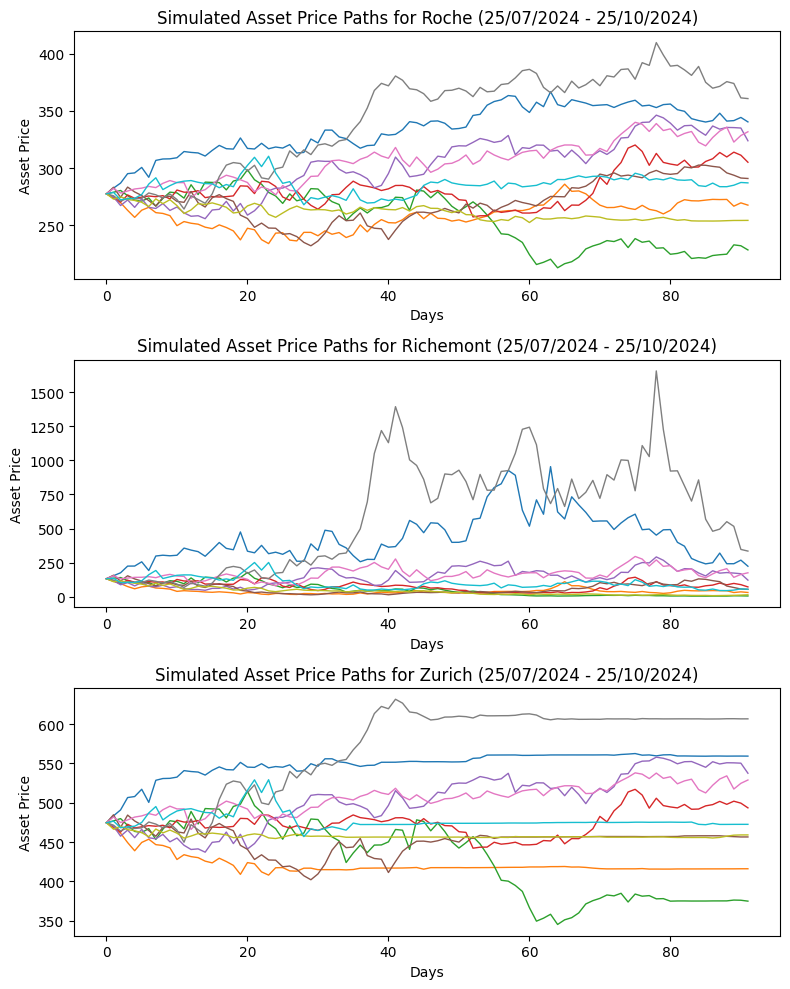

In [6]:
# Define the period for simulation
start_date = pd.to_datetime('2024-07-25')
end_date = pd.to_datetime('2024-10-25')
n_days = (end_date - start_date).days
n_steps = n_days
T = n_days / 252  # Convert days to fraction of a year
dt = 1 / 252  # Daily time step
n_simulations = 10000  # Number of simulations

# Risk-free rate
r = 0.0111  # Average risk-free rate, replace with actual average if available

# Calibrated Heston parameters for each asset
params_ROG = [0.102153095, 0.00105246972, 1.29684477, -0.340018539, 0.0400101339]
params_CFR = [9.99992882, 0.14767912, 0.49798847, -0.69982213, 0.03999396]
params_ZURN = [0.100084658, 0.00105243446, 1.99978233, -0.964662777, 0.0391291563]

# Initial stock prices
S0_ROG = 277.5
S0_CFR = 131.2
S0_ZURN = 474.6

# Function to simulate paths for one ticker
def simulate_paths(S0, V0, kappa, theta, sigma, rho, r, T, dt, n_steps, n_simulations):
    S_paths = np.zeros((n_steps, n_simulations))
    V_paths = np.zeros((n_steps, n_simulations))
    S_paths[0, :] = S0
    V_paths[0, :] = V0

    # Generate random variables
    np.random.seed(42)
    Z1 = np.random.normal(size=(n_steps, n_simulations))
    Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.normal(size=(n_steps, n_simulations))

    # Simulate the paths
    for t in range(1, n_steps):
        V_paths[t] = np.maximum(V_paths[t-1] + kappa * (theta - V_paths[t-1]) * dt + sigma * np.sqrt(V_paths[t-1] * dt) * Z1[t], 0)
        S_paths[t] = S_paths[t-1] * np.exp((r - 0.5 * V_paths[t]) * dt + np.sqrt(V_paths[t] * dt) * Z2[t])

    return S_paths

# Simulate paths for each ticker with respective parameters
S_paths_ROG = simulate_paths(S0_ROG, *params_ROG, r, T, dt, n_steps, n_simulations)
S_paths_CFR = simulate_paths(S0_CFR, *params_CFR, r, T, dt, n_steps, n_simulations)
S_paths_ZURN = simulate_paths(S0_ZURN, *params_ZURN, r, T, dt, n_steps, n_simulations)

# Create a single figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 10))

# Plotting the simulated paths for Roche
for i in range(10):  # Plot only a few paths
    axes[0].plot(S_paths_ROG[:, i], lw=1)
axes[0].set_title('Simulated Asset Price Paths for Roche (25/07/2024 - 25/10/2024)')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Asset Price')

# Plotting the simulated paths for Richemont
for i in range(10):  # Plot only a few paths
    axes[1].plot(S_paths_CFR[:, i], lw=1)
axes[1].set_title('Simulated Asset Price Paths for Richemont (25/07/2024 - 25/10/2024)')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Asset Price')

# Plotting the simulated paths for Zurich
for i in range(10):  # Plot only a few paths
    axes[2].plot(S_paths_ZURN[:, i], lw=1)
axes[2].set_title('Simulated Asset Price Paths for Zurich (25/07/2024 - 25/10/2024)')
axes[2].set_xlabel('Days')
axes[2].set_ylabel('Asset Price')

plt.tight_layout()
plt.show()

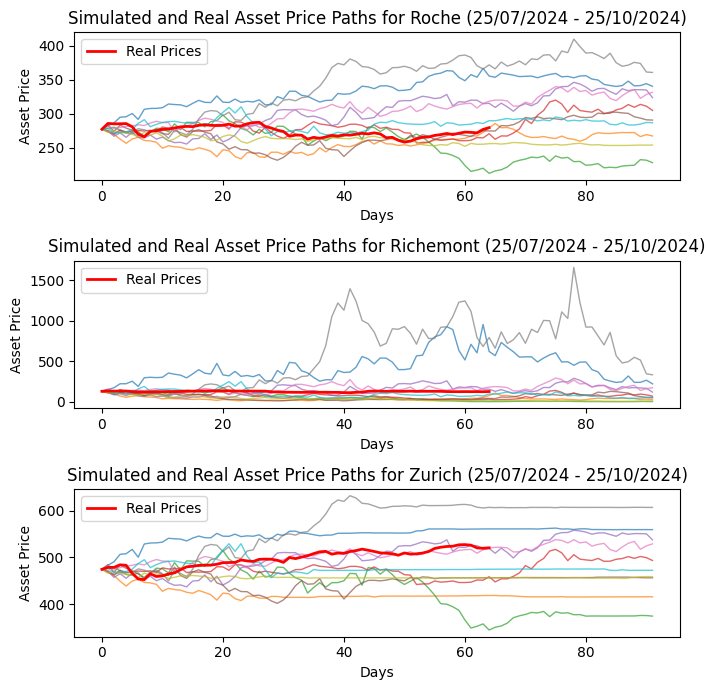

In [7]:
filtered_data = data[(data['Date'] >= '2024-07-25') & (data['Date'] <= '2024-10-24')]

# Extract the real prices
real_prices_ROG = filtered_data['ROG_Last_Price'].values
real_prices_CFR = filtered_data['CFR_Last_Price'].values
real_prices_ZURN = filtered_data['ZURN_Last_Price'].values
# Create a single figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(7, 7))

# Plotting the simulated and real paths for Roche
for i in range(10):  # Plot only a few paths
    axes[0].plot(S_paths_ROG[:, i], lw=1, alpha=0.7)
axes[0].plot(real_prices_ROG, lw=2, color='red', label='Real Prices')
axes[0].set_title('Simulated and Real Asset Price Paths for Roche (25/07/2024 - 25/10/2024)')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Asset Price')
axes[0].legend()

# Plotting the simulated and real paths for Richemont
for i in range(10):  # Plot only a few paths
    axes[1].plot(S_paths_CFR[:, i], lw=1, alpha=0.7)
axes[1].plot(real_prices_CFR, lw=2, color='red', label='Real Prices')
axes[1].set_title('Simulated and Real Asset Price Paths for Richemont (25/07/2024 - 25/10/2024)')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Asset Price')
axes[1].legend()

# Plotting the simulated and real paths for Zurich
for i in range(10):  # Plot only a few paths
    axes[2].plot(S_paths_ZURN[:, i], lw=1, alpha=0.7)
axes[2].plot(real_prices_ZURN, lw=2, color='red', label='Real Prices')
axes[2].set_title('Simulated and Real Asset Price Paths for Zurich (25/07/2024 - 25/10/2024)')
axes[2].set_xlabel('Days')
axes[2].set_ylabel('Asset Price')
axes[2].legend()

plt.tight_layout()
plt.show()


In [10]:
# Calculate the expected payoffs for the BRC product
payoffs = np.zeros(n_simulations)
for i in range(n_simulations):
    payoffs[i] = payoff_func(S_paths_ROG[:, i], S_paths_CFR[:, i], S_paths_ZURN[:, i])
# Calculate the average payoff
average_payoff = np.mean(payoffs)
print('Average Payoff:', average_payoff)

Hello
Worst performance: 1.321309128976571
Barrier event reached: False
Close above initial: 3
Hello
Worst performance: 0.24132105369337944
Barrier event reached: True
Close above initial: 2
Hello
Worst performance: 0.03741169262701412
Barrier event reached: True
Close above initial: 0
Hello
Worst performance: 0.5665797064713607
Barrier event reached: True
Close above initial: 2
Hello
Worst performance: 0.963635320328738
Barrier event reached: True
Close above initial: 2
Hello
Worst performance: 0.42387820226336836
Barrier event reached: True
Close above initial: 2
Hello
Worst performance: 1.2830798323257113
Barrier event reached: False
Close above initial: 3
Hello
Worst performance: 1.400501491705561
Barrier event reached: True
Close above initial: 3
Hello
Worst performance: 0.1077249032034836
Barrier event reached: True
Close above initial: 1
Hello
Worst performance: 0.4306900021837435
Barrier event reached: True
Close above initial: 2
Hello
Worst performance: 0.6892495992077015
Barr

In [12]:
payoffs.max()

1087.5

In [13]:
payoffs.min()

87.68969831951948

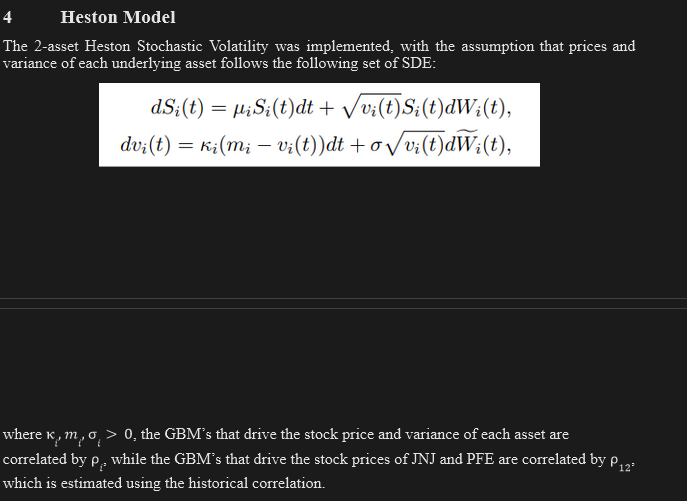